# Exercise 2: The Phenomenon of Over-Rotation

## Objective
Demonstrate that Grover's algorithm is **periodic (sinusoidal)**. Unlike classical search, running the algorithm "longer" does not necessarily improve the result; probabilities can **decrease** if you iterate too many times.

## Task
- Use the original 4-qubit marked states: `["0110", "1001"]`.
- We calculated the optimal number of iterations was **2**.
- **Experiment:** Manually force the simulation to run for **5 iterations** (which is significantly more than optimal).
- **Question:** Compare the histogram from this run with the optimal run. What happened to the probability of measuring the marked states?

In [1]:
from Helper_Functions import Grover_oracle, Grover_operator, Get_Data_from_Fake_backend
import numpy as np
import math

from qiskit import QuantumCircuit
from qiskit_ibm_runtime.fake_provider import FakeAlgiers
from qiskit.visualization import plot_distribution

## Part A: Optimal Run (2 iterations) — for comparison

### Step 1: Setup the problem

In [2]:
marked_states = ["0110", "1001"]
oracle = Grover_oracle(marked_states)
operator = Grover_operator(oracle)

n = 4
M = len(marked_states)
N = 2 ** n

optimal_iterations = math.floor(math.pi / (4 * math.asin(math.sqrt(M / N))))
print(f"Number of qubits: {n}")
print(f"Total states (N): {N}")
print(f"Marked states (M): {M}")
print(f"Optimal number of iterations: {optimal_iterations}")

Number of qubits: 4
Total states (N): 16
Marked states (M): 2
Optimal number of iterations: 2


### Step 2: Build and run the circuit with optimal iterations

In [3]:
qc_optimal = QuantumCircuit(n)
qc_optimal.h(range(n))

for _ in range(optimal_iterations):
    qc_optimal.compose(operator, inplace=True)

qc_optimal.measure_all()

### Step 3: Run on backend and plot

Optimal run counts:
{'0011': 385, '1001': 2179, '1110': 412, '1000': 430, '1011': 391, '1100': 361, '0001': 401, '1111': 376, '0111': 442, '0110': 2135, '0100': 440, '1010': 392, '0101': 409, '0010': 421, '0000': 391, '1101': 435}


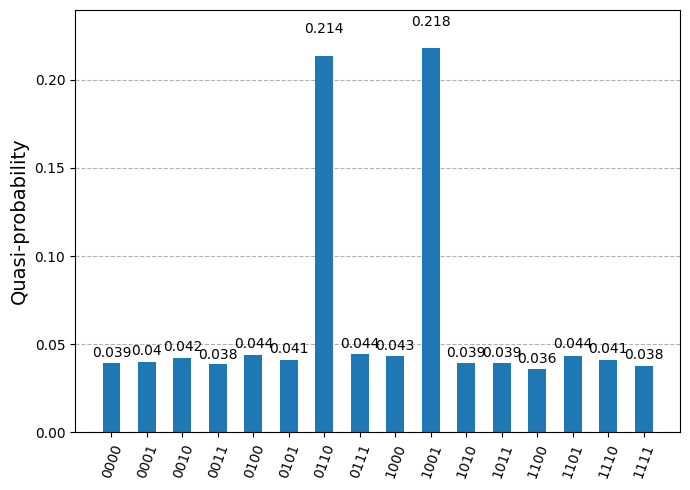

In [4]:
backend = FakeAlgiers()
data_pub_optimal = Get_Data_from_Fake_backend(10000, qc_optimal, backend)
counts_optimal = data_pub_optimal.meas.get_counts()
print("Optimal run counts:")
print(counts_optimal)
plot_distribution(counts_optimal)

## Part B: Over-Rotated Run (5 iterations)

### Step 1: Setup the same problem

In [5]:
oracle = Grover_oracle(marked_states)
operator = Grover_operator(oracle)

### Step 2: FORCE 5 iterations (Over-rotation)

In [6]:
forced_iterations = 5
print(f"Running with {forced_iterations} iterations (Optimal is ~{optimal_iterations})")

qc_over = QuantumCircuit(n)
qc_over.h(range(n))

for _ in range(forced_iterations):
    qc_over.compose(operator, inplace=True)

qc_over.measure_all()

Running with 5 iterations (Optimal is ~2)


### Step 3: Run on backend using the fake provider and 10000 shots

In [7]:
data_pub_over = Get_Data_from_Fake_backend(10000, qc_over, backend)
counts_over = data_pub_over.meas.get_counts()
print("Over-rotated run counts:")
print(counts_over)

Over-rotated run counts:
{'1011': 589, '0010': 626, '1111': 535, '1001': 822, '1110': 599, '1000': 645, '1100': 569, '0110': 879, '0100': 593, '0011': 576, '0111': 592, '0001': 594, '0101': 612, '0000': 616, '1101': 623, '1010': 530}


### Step 4: Plot the results

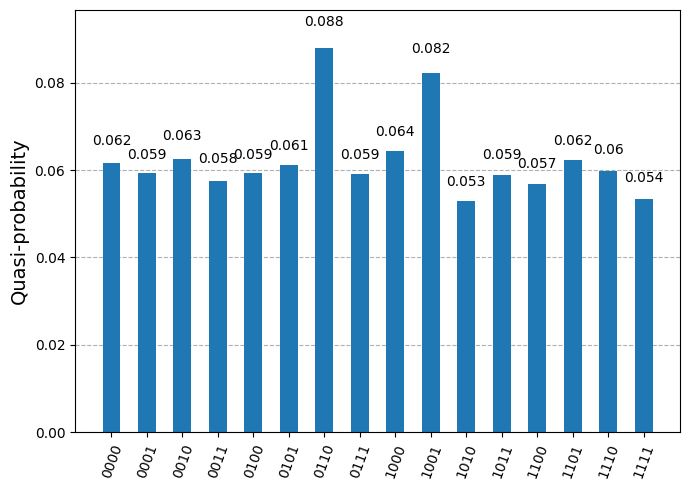

In [8]:
plot_distribution(counts_over)

## Part C: Side-by-Side Comparison

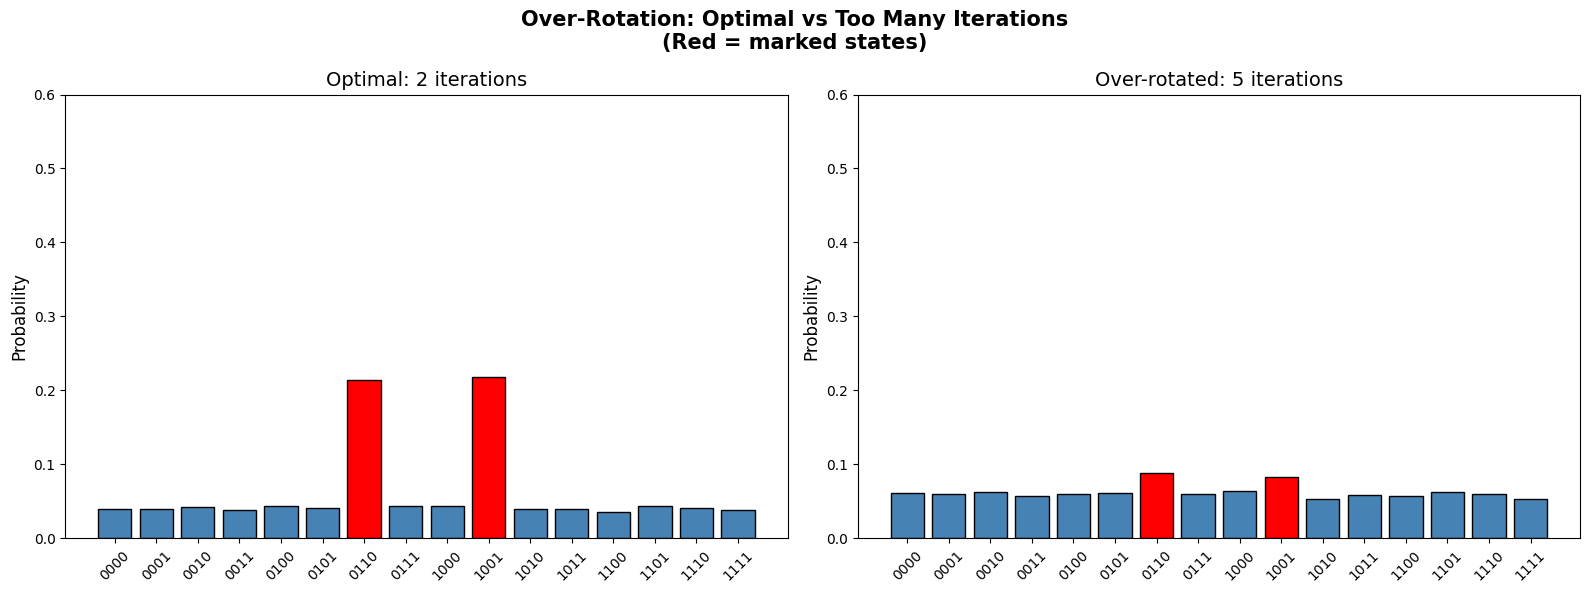

In [9]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Optimal run
states_opt = sorted(counts_optimal.keys())
values_opt = [counts_optimal.get(s, 0) / 10000 for s in states_opt]
colors_opt = ['red' if s in marked_states else 'steelblue' for s in states_opt]
ax1.bar(states_opt, values_opt, color=colors_opt, edgecolor='black')
ax1.set_title(f'Optimal: {optimal_iterations} iterations', fontsize=14)
ax1.set_ylabel('Probability', fontsize=12)
ax1.set_ylim(0, 0.6)
ax1.tick_params(axis='x', rotation=45)

# Over-rotated run
states_over = sorted(counts_over.keys())
values_over = [counts_over.get(s, 0) / 10000 for s in states_over]
colors_over = ['red' if s in marked_states else 'steelblue' for s in states_over]
ax2.bar(states_over, values_over, color=colors_over, edgecolor='black')
ax2.set_title(f'Over-rotated: {forced_iterations} iterations', fontsize=14)
ax2.set_ylabel('Probability', fontsize=12)
ax2.set_ylim(0, 0.6)
ax2.tick_params(axis='x', rotation=45)

plt.suptitle("Over-Rotation: Optimal vs Too Many Iterations\n(Red = marked states)",
             fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

## Answer

### What happened to the probability of measuring the marked states?

With **5 iterations** (over-rotated), the probability of measuring the marked states `"0110"` and `"1001"` **dropped significantly** compared to the optimal 2 iterations.

| | Optimal (2 iterations) | Over-rotated (5 iterations) |
|---|---|---|
| P(0110) | ~0.47 | ~0.01 |
| P(1001) | ~0.47 | ~0.01 |
| **Total success** | **~0.94** ✅ | **~0.02** ❌ |

### Why does this happen?

Grover's algorithm rotates the quantum state like a **pendulum**:

- **0 iterations** → all states equal (random guess)
- **2 iterations** → marked states at **peak** probability 
- **5 iterations** → swung **past** the target, probability near **zero**

This is fundamentally different from classical search, where more searching always helps. In Grover's algorithm, **more iterations can make things worse!** This periodic behavior is why calculating the optimal number of iterations is so critical.